In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
from collections import Counter
import re

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Загрузим файл на виртуальную среду 

In [3]:
idd = '1dAaDSuWAdQaSNEN5Xp67SBg0ALtKJowr'
downloaded_ = drive.CreateFile({'id':idd}) 
downloaded_.GetContentFile('train.csv')

import pandas as pd 
train = pd.read_csv('train.csv', sep=';')

Так как задачей является классификация продуктов, поэтому информацией заложенной в названии категорий мы можем пренебречь. 
<br>Замапим категории, чтобы в дальнейшем номер категори можно было использовать как индекс единицы в one hot encoding (расчет Лосс функции), или в терминах вероятности, модель училась генерировать близкое к верному вероятностное распределние, например [1,0,0...0] (распределение для нулевой категори)

In [4]:
transform = {i: str(indx) for indx, i in enumerate(train.category.unique())}
def transorm_(x):
  return transform[x]
train['labels'] = train['category'].apply(transorm_)
train.head()

,descr,category,labels
0,ЯСНЫЕ ЗОРИ Филе ЦБ п/ф зам.подл.1кг,Замороженное мясо птицы,0
1,Вино ALESAN BORD.11.5%кр. 0.75л,Вино тихое,1
2,Карбонат ГУРМАН ЮБИЛЕЙНЫЙ 1кг,Деликатесы,2
3,Фисташки ЛЕДНИКОВЫЙ ПЕРИОД жар.сол.250г,Орехи,3
4,Грудинка ЮЖНАЯ в/к в/с 1кг,Деликатесы,2


# EDA

Построим гистограмму распределения классов на тренировочной выборке.  

31836 Колбасные изделия


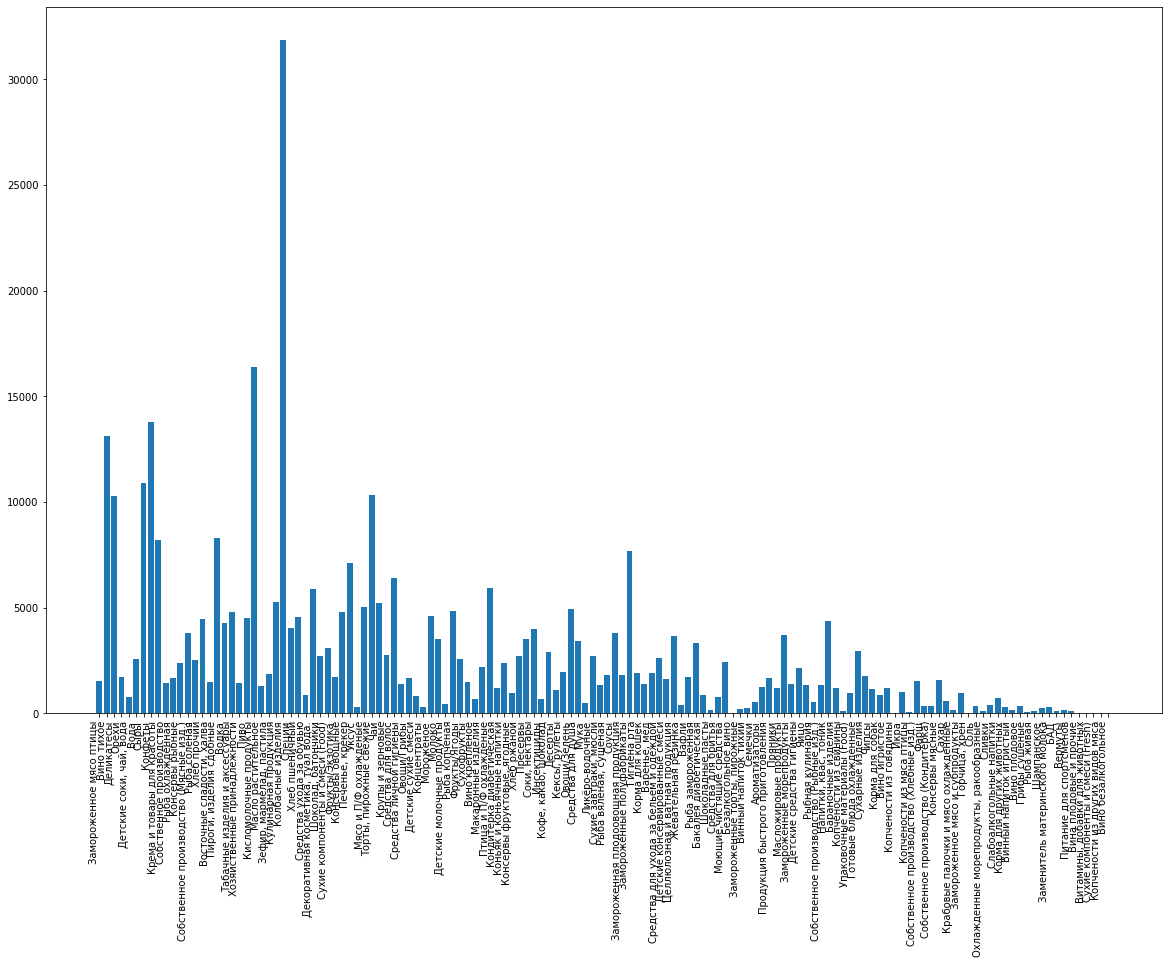

In [5]:
plt.figure(figsize=(20, 13))
to_bCh = Counter(train.category.tolist()).items()
h = [j for i,j in to_bCh]
lbls = [i for i,j in to_bCh]
plt.bar(range(len(transform)),h ,tick_label = lbls)
print(max(h), lbls[h.index(max(h))])
plt.xticks(rotation=90, ha='right')
plt.show()

In [6]:
to_bCh = sorted(to_bCh, key=lambda x: x[1], reverse = True)
print('Категории, содержащие наименьшим количество товаров в тренировочной выборке:')
for name, value in list((to_bCh))[:129:-1]:
  print( name, ':', value) 

Категории, содержащие наименьшим количество товаров в тренировочной выборке:
Вино безалкогольное : 2
Сухие компоненты и смеси (Fresh) : 6
Копчености из других видов мяса : 9
Вина плодовые и прочие : 11
Копчености из говядины : 11
Горчица, хрен : 17
Безалкогольное вино : 18
Витамины, добавки для животных : 34


In [7]:
sum_values = 0
for name, value in list((to_bCh))[:129:-1]:
  sum_values+=value
print('Процентное соотношение товаров редких категории относительно тернировачной выборки - {0:0.2f}'.format(sum_values/train.shape[0]*100))

Процентное соотношение товаров редких категории относительно тернировачной выборки - 0.03


В целом, этими классами можно перенебречь, так как в них содержится менее 0.03% от общего количества товаров.  Кроме того, в дальнейшем, для оценки результатов будут использваться взвешенные метрики, что позволит невелировать ошибки(если таковые будут), касающиеся этих категорий.

Проведем предобработку названий

In [8]:
def clear(x):
  #x = ' '.join([i for i in re.findall('[^a-zA-Z]+', str(x).lower())])
  #x = re.sub('[\.%]',' ', x)
  x = re.sub('[0-9]+','', str(x).lower()) # Числовые значения хоть и косвенно несут информацию о категории продукта, однако они не стандартизированы и в при таких объемах могут создавать шум
  x = re.sub('[\.\-\+,"/%№]',' ', x) # заменим занки препинания и спец символы на пробелы
  x = re.sub('\s+',' ', x) # 
  
  return x

train['cl_descr'] = train.descr.apply(clear)
train.tail(40)

,descr,category,labels,cl_descr
368907,MILKA Конф.KLEINES DANKES.из мол.шок110г,Конфеты,7,milka конф kleines dankes из мол шокг
368908,Вино КАМБРАС бел.сух.0.7л,Вино тихое,1,вино камбрас бел сух л
368909,ШОЛОХОВ.ХК Булочка с вишней в/с 80г,"Пироги, изделия сдобные",16,шолохов хк булочка с вишней в с г
368910,SCHARD.Сыр АЛЬПЦИРЛЕР 50% 1кг,Сыры,6,schard сыр альпцирлер кг
368911,ПЕТЕЛИНКА Бедро ОСОБОЕ в чесн.соусе 1кг,Птица и П/Ф охлажденые,53,петелинка бедро особое в чесн соусе кг
368912,COEUR DU NORD Сыр БЮШ МОЛОД.мяг.45% 130г,Сыры,6,coeur du nord сыр бюш молод мяг г
368913,SALAM.Крем NUB.-VEL.т/кор. 75мл,Средства ухода за обувью,28,salam крем nub vel т кор мл
368914,СЛАДА Карамель Драже Лимончики 1кг,Конфеты,7,слада карамель драже лимончики кг
368915,Набор д/бульона куриный заморож.подл.1кг,Замороженное мясо птицы,0,набор д бульона куриный заморож подл кг
368916,Капуста Молодая свежая отеч,Овощи/Грибы,42,капуста молодая свежая отеч


In [9]:
len(train.labels.unique())

138

Построим гистограмму распределения длин слов. Она позволит нам примерно оценить, сколько информации мы можем потерять если почистим названя продуктов от слов длины 2 и менее. 

[248680, 308866, 265854, 491535, 330768, 192501, 112203, 54822, 31496, 182798]


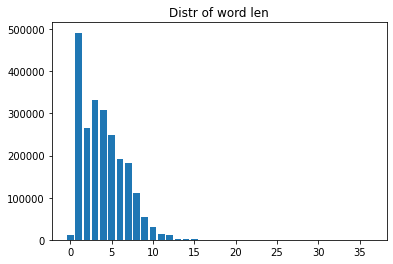

In [10]:
words = [word for text in train.cl_descr.tolist() for word in text.split(' ')]
m_f  = [w for w, fr in Counter(words).most_common(15)]
len_w_dist = [len(word) for word in words]
#print([len_word for len_word, fr in Counter(len_w_dist).items()])
a = [fr for len_word, fr in Counter(len_w_dist).items()]
print(a[:10])
plt.bar([len_word for len_word, fr in Counter(len_w_dist).items()], [fr for len_word, fr in Counter(len_w_dist).items()])
plt.title('Distr of word len')
plt.show()

Из гистограммы следует, что встречамость слов длиной 2 и менее в нашем датасете весьма велика, поэтому пренебрегать этой информацией не стоит. Скорее всего даже подходящие ко многим категория марекеры "кг", "мл" и т.д. могут иметь важное значение при классификации.

Нужна ли нормализация?

In [11]:
unique_words = set(words)
len(unique_words)

73891

In [ ]:
!pip install pymorphy2

In [ ]:
import pymorphy2
from tqdm import tqdm
morph = pymorphy2.MorphAnalyzer()
lemmas = []
for word in tqdm(set(words)):
  lemmas.append(morph.parse(word)[0].normal_form)

100%|██████████| 73891/73891 [00:13<00:00, 5368.89it/s]


In [ ]:
unique_lemmas = set(lemmas)
len(unique_lemmas)

64291

Нормализация позволяет уменьшить вокабуляр на 10000 единиц. Однако, логично предположить, что существительные в названии продуктов, в большинстве своем, итак находятся в именительном падеже, прилагательные варьируются, а глаголы практически не используются. Проверим 

In [ ]:
print('Процентное содержание лемм в исходном словаре : {0:.2f} %'.format(len(unique_words & unique_lemmas) / len(unique_words) * 100))

Процентное содержание лемм в исходном словаре : 66.38 %


In [ ]:
list(unique_words & unique_lemmas)[:100]

['',
 'фазер',
 'cheezotto',
 'пласшт',
 'оригинал',
 'минибокс',
 'джеймс',
 'wandemoortele',
 'xaaxt',
 'delle',
 'dreamies',
 'galicia',
 'ерр',
 'фрескел',
 'choise',
 'венеция',
 'killer',
 'mirabo',
 'сифон',
 'былычок',
 'анкудиновский',
 'корпус',
 'chas',
 'моющеег',
 'поскр',
 'бризкал',
 'снх',
 'фуркадэ',
 'serignan',
 'salfeti',
 'вернли',
 'сырмоцарелла',
 'смолли',
 'пиквар',
 'киевск',
 'пастуший',
 'bano',
 'schoget',
 'профреш',
 'чеснок',
 'текила',
 'конц',
 'монфлери',
 'колблюбитпраймродославныефамк',
 'постников',
 'carol',
 'вммт',
 'halva',
 'mattioni',
 'patissier',
 'днк',
 'горб',
 'балиш',
 'тортиллас',
 'herbarium',
 'рольмоп',
 'кскг',
 'salen',
 'maximizing',
 'ногин',
 'протёртый',
 'шокo',
 'joli',
 'вилк',
 'визит',
 'carl',
 'султанск',
 'йогурт',
 'aprior',
 'кешир',
 'неробьян',
 'pontet',
 'плиточ',
 'шелккг',
 'шампуньос',
 'востокаг',
 'чурчхелла',
 '*гр',
 'флоренциякок',
 'улетайка',
 'обеденный',
 'звенигородский',
 'голландс',
 'elin',
 'sed

Теперь стоит проверить качестсво слов, которых мы лишаемся при лемматизации. 

In [ ]:
diff = list(set(words) - set(lemmas))[:50]
for indx, word in enumerate(diff):
  print("До : ",diff[indx], "\t\t\tПосле : ", morph.parse(word)[0].normal_form )

До :  градин 			После :  градина
До :  бельгийское 			После :  бельгийский
До :  мусульманские 			После :  мусульманский
До :  отборные 			После :  отборный
До :  паток 			После :  патока
До :  бирскив 			После :  бирскива
До :  декорирования 			После :  декорирование
До :  вафлях 			После :  вафля
До :  ваксит 			После :  ваксить
До :  бифидобактериям 			После :  бифидобактерия
До :  семеновна 			После :  семён
До :  цикла 			После :  цикл
До :  бородинскийтрадиц 			После :  бородинскийтрадица
До :  тушек 			После :  тушка
До :  шоколастики 			После :  шоколастик
До :  берестов 			После :  берест
До :  премиалиное 			После :  премиалиный
До :  десе 			После :  дес
До :  обоев 			После :  обои
До :  д`ож 			После :  д`ожий
До :  суниформ 			После :  суниформа
До :  м 			После :  метр
До :  лепила 			После :  лепить
До :  рождественская 			После :  рождественский
До :  сухая 			После :  сухой
До :  атлантис 			После :  атлантиса
До :  елисеевские 			После :  елисеевский
До :  шейкера 		

Можно заметить, что примерно в половине случаев, лемматизатор придумывает слова и не уменьшает пространство наших признаков. 

Таким образом, можно сделать вывод, что леммантизация имеет относительно невысокое значение в данной таске и возможно не приведет к улучшению точности, тем более, что пространствов признаков для каждого текста будет считаться с помощью тф-идф и искуственно расширяться по средствам включения биграмм.

## MLP

Согласно гипотезе Колмогорова, любую функцию можно апроксимировать трехслойным перцептроном с некоторыми параметрами, зависящиими от количества переменных. С него и начнем.

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics

Поделим данные на трейн и тест для того чтобы иметь возможность объективно оценить модели. При векторизации текстов используем тф-идф на уровне слова. Используем биграммы, чтобы отловить устойчивые сочетания в названии продуктов. Редкими словами будем пренебригать (меньше 5 вхождений), подключим стоп слова - наиболее частотные для этого датасета (12 - так как их частотности в несколько раз превышают последующие). 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# эту строчку не меняйте, будете делать тестирование(между эпохами) на этой небольшой выборке 
text_trian, text_test, labels_train, labels_test =  train_test_split(train.cl_descr, train.labels, test_size=0.05, random_state=42)

tf_transformer = ....
X_train_transformed = ...
X_test_transformed = ....
X_train_transformed.shape # первая размерноть точно будет такой (350499, х)

(350499, 68024)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import time

In [ ]:
import torch
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

class WordData(Dataset):
    
    def __init__(self, x_data, y_data):
        
        super().__init__()
        
        self.x_data = x_data #пусть будет сохранен в память класса
        self.y_data = torch.LongTensor(y_data) #а это как тензор
        
    
    def __len__(self): # объязательный метод для этого класса, нужно уметь отдавать длину датасета 
        
        return self.x_data.shape[0] 
    
    def __getitem__(self, idx): # объязательный метод для этого класса, нужно уметь отдавать один семпл с данными и лейблом
        
        x = self.x_data[idx].toarray() # Будьте аккуратны, когда используете sparse matrix, так как изначально преобразовать их в массив нельзя - память кончится, будем препращать в массив отдельные строчки
        x = torch.FloatTensor(x) # преобразуем в тензор с флоат величинами
        y = self.y_data[idx]
        
        return x, y


dataset_train = # задайте датасет для трейна
dataset_test = #зададйте датасет для теста

batch_size = # задайте батч сайз

train_loader = # создайте дата лоадер и перемешайте в нем примеры для трейна
validation_loader =  # создайте дата лоадер и перемешайте в нем примеры для теста



In [ ]:
from math import sqrt
class MLP(torch.nn.Module):
    
    def __init__(self, in_features, inner_features, inner_features2, out_features):
        
        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать 
        # в целом трех слоев будет достаточно

       ....
        self.linear_3 = torch.nn.Linear(in_features=inner_features2, out_features=out_features) # out_features - количество категорий товаров, по которым вы хотите классифицировать, т.е. 138
  
    def forward(self, x):
        
        # наша привычная схема
        
        ....
        x = self.linear_3(x) # это должен быть послдений слой в котором меняется размерность, никаких нелинейностей применть не нужно, софтмакс в Торче встроен в в кросс-энтропию для оптимизации
        
        return x
    

In [ ]:
model = MLP(in_features=tf_res.shape[1], inner_features=1524, inner_features2=1024, out_features=138)

In [ ]:
model

In [ ]:
for x, y in train_loader:
  print(model(x).shape)
  break #посмотрите внимательно на размерность

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001,  betas=(0.9, 0.999) ) # это один из крутых оптимизаторв, можете для начала опробовать SGD
# aka loss function
criterion = torch.nn.CrossEntropyLoss() # будем считать потери с помощью привычной кросс энтропии

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device) # если мы работает на торче, можно оставить как есть; суть в том, что нашу модель можно перенести на видеокарту, 
                         # потом мы будем переводить туда и батчи с данными, это позволит нам обучаться быстрее, раз 5 как минимум

In [ ]:
from sklearn.metrics import f1_score
epochs = 2

losses = []
predictions = []

for n_epoch in range(epochs):
  print('Epoch #{}\n'.format(n_epoch+1))

  train_losses = []
  train_predictions = []

  for x, y in train_loader:

    optimizer.zero_grad()

    x = x.squeeze(1).to(device) # так как наша модель уже на ГПУ нужно и данные тоже туда пренести, кстати функция сквиз здесь это нормально, просто у нас есть лишняя развмерность и мы от нее избавляемся
    y = y.to(device)

    # допиште обучалку, при этом следите за размерностями
        
  print('\n\nMean Loss after epoch #{0} - {1}'.format(str(n_epoch + 1), np.mean(losses)))
  print('F1 score after epoch #{0} on train - {1}\n'.format(str(n_epoch + 1), np.mean(predictions)))

  test_predicteds = []
  test_labels = []
  test_loss = []

  with torch.no_grad():
    for x, y  in validation_loader:
      outputs = model(x.squeeze(1).to(device))
      _, predicted = torch.max(outputs.cpu().data, 1)
      loss = criterion(outputs.cpu(), y)
      test_loss.append(loss.item())
      test_labels.extend(y)
      test_predicteds.extend(predicted)
        

  f = f1_score(test_predicteds, test_labels, average = 'weighted')  
  print('\nLoss on test: {}'.format(np.mean(test_loss)))   
  print('F1 on test: {}\n\n'.format(f))
  